In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import antropy as ant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from pycaret.classification import *
from scipy.stats import skew, kurtosis


## MNE starter code

Using default location ~/mne_data for PHYSIONET_SLEEP...


Extracting EDF parameters from C:\Users\utkar\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.
Opening raw-browser...


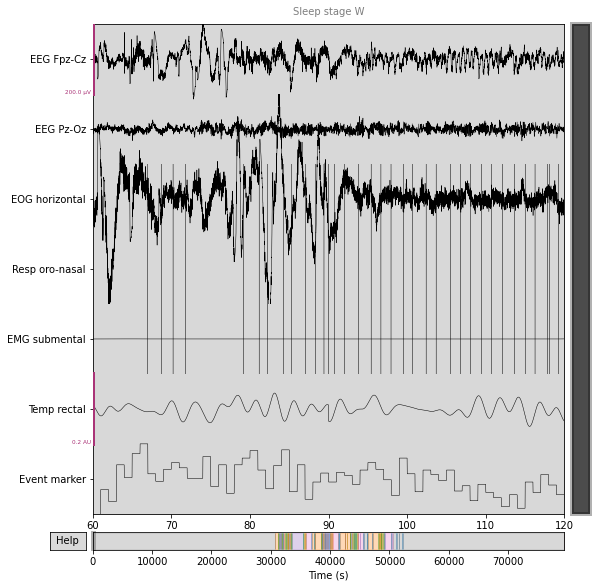

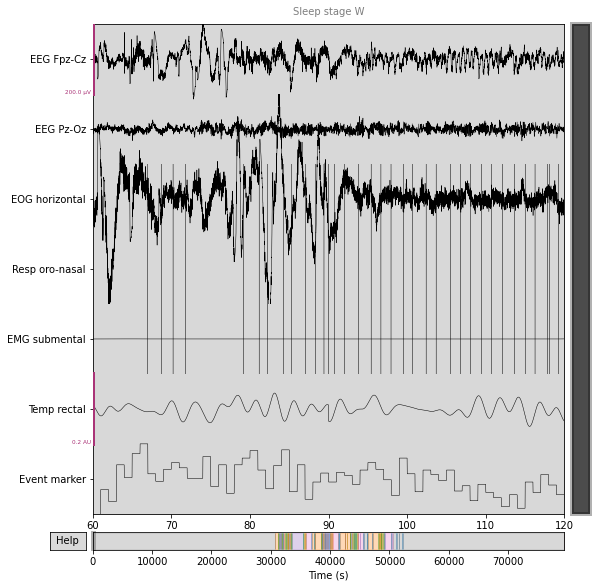

In [3]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)



In [9]:

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))dd

Opening raw-browser...


## Own code

In [138]:

EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
for subject in tqdm(os.listdir(EEG_path)):
    print(subject, end='\r')
    raw_train=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        print(file)
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw_train = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw_train.set_annotations(annot_train, emit_warning=False)
            
    # raw_train.plot(start=60, duration=60,
    #         scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
    #                         misc=1e-1))
    tqdm.write(f"Annotations {annot_train}", end='\r')
    

  0%|          | 0/44 [00:00<?, ?it/s]

ST7101J0-PSG.edf
Extracting EDF parameters from C:\Users\utkar\Desktop\Research_Paper\EEG Analysis\Sleep_Stage_Detection\sleep-edf-database-expanded-1.0.0\sleep-edf-database-expanded-1.0.0\sleep-telemetry\subject101\ST7101J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3295999  =      0.000 ... 32959.990 secs...
ST7101JE-Hypnogram.edf
ST7102J0-PSG.edfotations | 161 segments: Movement time (6), Sleep stage 1 (20), Sleep ...>
Extracting EDF parameters from C:\Users\utkar\Desktop\Research_Paper\EEG Analysis\Sleep_Stage_Detection\sleep-edf-database-expanded-1.0.0\sleep-edf-database-expanded-1.0.0\sleep-telemetry\subject102\ST7102J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2981999  =      0.000 ... 29819.990 secs...
ST7102JE-Hypnogram.edf
ST7011J0-PSG.edfotations | 101 segments: Movement time (5), Sleep stage 1 (8), Sleep ...>
Extracting EDF parameters from C:\Us

In [65]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)

    # ant.svd_entropy(row[i-500:i], normalize=True
    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    svd_entropies = np.zeros((n_epochs, n_channels))
    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            svd_entropies[i, j] = ant.svd_entropy(channel_data)

    X = svd_entropies
    Y = epochs_train.events[:, -1]

    return X, Y

In [5]:
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
subject_hyp = "ST7011JP-Hypnogram.edf"
subject_PSG = "ST7011J0-PSG.edf"

In [71]:
import logging
import sys
mne.set_log_level(logging.WARNING)

## Calling the function

In [56]:
X_all, Y_all = [], []

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X, Y = process_edf(subject)
    X_all.append(X)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [57]:
X_all = np.vstack(X_all)
Y_all = np.concatenate(Y_all)

In [58]:
df_X1 = pd.DataFrame(X_all)
df_Y1 = pd.DataFrame(Y_all)

In [59]:
df_X1

0         1         2         3             4
0       1.538492  1.567789  1.501203  1.583811  4.572279e-01
1       1.044986  0.677884  0.545683  1.542533  2.021077e-13
2       0.976760  1.112264  0.767481  1.555846  2.021077e-13
3       1.235021  1.020494  0.667458  1.579904  2.021077e-13
4       0.617544  0.739560  0.580067  1.583355  2.021077e-13
...          ...       ...       ...       ...           ...
124467  0.981737  1.126553  0.983271  1.400993  2.021077e-13
124468  0.787541  1.422583  0.631935  1.455460  2.021077e-13
124469  0.796914  1.382732  0.686398  0.904002  2.021077e-13
124470  0.750976  1.379541  0.438738  0.655126  2.021077e-13
124471  1.271833  0.993736  0.859421  0.828574  2.679158e-01

[124472 rows x 5 columns]

In [60]:
df_Y1.value_counts()

2    57948
4    24447
3    19245
0    12446
1    10386
dtype: int64

In [61]:
df_input = pd.concat([df_X1, df_Y1], axis=1)
df_input.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker', 'Sleep stage']
#df_input = df_input.drop(['Marker'], axis=1)
df_input

EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  EMG submental        Marker  \
0         1.538492   1.567789        1.501203       1.583811  4.572279e-01   
1         1.044986   0.677884        0.545683       1.542533  2.021077e-13   
2         0.976760   1.112264        0.767481       1.555846  2.021077e-13   
3         1.235021   1.020494        0.667458       1.579904  2.021077e-13   
4         0.617544   0.739560        0.580067       1.583355  2.021077e-13   
...            ...        ...             ...            ...           ...   
124467    0.981737   1.126553        0.983271       1.400993  2.021077e-13   
124468    0.787541   1.422583        0.631935       1.455460  2.021077e-13   
124469    0.796914   1.382732        0.686398       0.904002  2.021077e-13   
124470    0.750976   1.379541        0.438738       0.655126  2.021077e-13   
124471    1.271833   0.993736        0.859421       0.828574  2.679158e-01   

        Sleep stage  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
124467            0  
124468            0  
124469            0  
124470            0  
124471            0  

[124472 rows x 6 columns]

In [62]:
clf = setup(
    data=df_input, 
    target='Sleep stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True
    )

In [63]:
compare_models(fold=15)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

## Mean, Kurtosis etc method

In [69]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)

    data = epochs_train.get_data()

    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = skew(data, axis=2)
    kurt = kurtosis(data, axis=2)

    X = np.concatenate((mean, std_dev, skewness, kurt), axis=1)
    Y = epochs_train.events[:, 2]


    return X, Y

In [78]:
X_all, Y_all = [], []

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X, Y = process_edf(subject)
    X_all.append(X)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

(1042, 20)


In [77]:
X_all.shape

(41490, 20)

In [81]:
X_all = np.vstack(X_all)
Y_all = np.concatenate(Y_all)

In [82]:
df_X1 = pd.DataFrame(X_all)
df_Y1 = pd.DataFrame(Y_all)

In [83]:
df_X1

0             1         2             3         4         5   \
0     2.399543e-07 -2.199316e-07  0.000100  1.337692e-05 -2.906667  0.000116   
1     2.975980e-07  5.223015e-08 -0.000119  4.629189e-07  2.000000  0.000072   
2     6.483799e-08  2.569144e-07  0.000116  5.561863e-07  3.706667  0.000050   
3    -2.353310e-06 -2.351883e-07 -0.000166  1.233596e-06  2.000000  0.000093   
4     6.890973e-07  1.820810e-07  0.000017  1.975218e-07  2.000000  0.000114   
...            ...           ...       ...           ...       ...       ...   
1037  9.261540e-07 -1.042471e-06 -0.000004 -5.029604e-08  2.000000  0.000051   
1038 -7.610171e-07  4.552829e-07  0.000026 -7.324666e-09  2.000000  0.000053   
1039  8.739625e-07 -1.423588e-07 -0.000012  2.420802e-07  2.000000  0.000034   
1040  2.370446e-07  8.278544e-07  0.000014  3.563816e-06  2.000000  0.000089   
1041 -3.576431e-07 -1.432365e-07 -0.000095 -2.809681e-05 -2.373333  0.000098   

            6         7         8          9         10        11        12  \
0     0.000104  0.000272  0.000124  14.423290 -3.075678  1.332415 -0.821078   
1     0.000048  0.000263  0.000020   0.000000  1.477339  1.045068  0.098621   
2     0.000034  0.000241  0.000023   7.190314  2.178262 -0.424238  0.756337   
3     0.000066  0.000214  0.000019   0.000000  0.972742  1.240378 -0.476201   
4     0.000052  0.000195  0.000014   0.000000  1.527443  0.353598 -0.498222   
...        ...       ...       ...        ...       ...       ...       ...   
1037  0.000034  0.000023  0.000003   0.000000 -0.169881 -0.790499  0.719036   
1038  0.000036  0.000028  0.000003   0.000000  0.360942 -0.189881 -0.117076   
1039  0.000028  0.000019  0.000002   0.000000  0.224439  0.012945 -0.210545   
1040  0.000036  0.000183  0.000021   0.000000  1.782222  0.820633 -0.999454   
1041  0.000027  0.000312  0.000069  10.991843  2.280506 -0.169163  0.096297   

            13        14          15          16         17          18  \
0    -6.740439 -0.614591  291.523782  201.569396  13.635766  338.614692   
1    -0.657815  0.000000    3.276232    4.301412  -0.663105    7.638272   
2    -0.020747  3.975719    7.854767    4.168572   0.916823    5.337252   
3    -0.250570  0.000000    3.591780    5.138569  -0.413813    7.690777   
4     0.246536  0.000000    1.632868    6.017006  -0.108143    2.962941   
...        ...       ...         ...         ...        ...         ...   
1037  0.101227  0.000000    0.643070    2.040151   4.922845   -0.567273   
1038  0.181987  0.000000    1.602112    1.388202   0.238636   -0.384016   
1039  0.198727  0.000000   -0.076910    0.197933   0.466827   -0.056777   
1040 -0.376207  0.000000    4.657739    3.267820   1.139962    3.122838   
1041 -1.548955 -2.115508    9.073125    4.611170   0.460147    1.299877   

             19  
0      0.947914  
1     -3.000000  
2     13.806338  
3     -3.000000  
4     -3.000000  
...         ...  
1037  -3.000000  
1038  -3.000000  
1039  -3.000000  
1040  -3.000000  
1041   2.475374  

[1042 rows x 20 columns]

In [74]:
df_Y1.value_counts()

2    19316
4     8149
3     6415
0     4148
1     3462
dtype: int64

In [96]:
df_input = df_X1

In [97]:
df_input.columns = ['mean_EEG_Fpz-Cz', 'mean_EEG_Pz-Oz', 'mean_EOG_horizontal', 'mean_EMG_submental', 'mean_Marker',\
        'std_dev_EEG_Fpz-Cz', 'std_dev_EEG_Pz-Oz', 'std_dev_EOG_horizontal', 'std_dev_EMG_submental', 'std_dev_Marker',\
        'skew_EEG_Fpz-Cz', 'skew_EEG_Pz-Oz', 'skew_EOG_horizontal', 'skew_EMG_submental', 'skew_Marker',\
        'kurtosis_EEG_Fpz-Cz', 'kurtosis_EEG_Pz-Oz', 'kurtosis_EOG_horizontal', 'kurtosis_EMG_submental', 'kurtosis_Marker',]
df_input = pd.concat([df_X1, df_Y1], axis=1)
#df_input = df_input.drop(['Marker'], axis=1)
df_input.rename(columns={0: 'Sleep stage'}, inplace=True)
df_input.drop(['mean_Marker', 'std_dev_Marker', 'skew_Marker', 'kurtosis_Marker'], axis=1, inplace=True)
df_input

mean_EEG_Fpz-Cz  mean_EEG_Pz-Oz  mean_EOG_horizontal  \
0        2.399543e-07   -2.199316e-07             0.000100   
1        2.975980e-07    5.223015e-08            -0.000119   
2        6.483799e-08    2.569144e-07             0.000116   
3       -2.353310e-06   -2.351883e-07            -0.000166   
4        6.890973e-07    1.820810e-07             0.000017   
...               ...             ...                  ...   
1037     9.261540e-07   -1.042471e-06            -0.000004   
1038    -7.610171e-07    4.552829e-07             0.000026   
1039     8.739625e-07   -1.423588e-07            -0.000012   
1040     2.370446e-07    8.278544e-07             0.000014   
1041    -3.576431e-07   -1.432365e-07            -0.000095   

      mean_EMG_submental  std_dev_EEG_Fpz-Cz  std_dev_EEG_Pz-Oz  \
0           1.337692e-05            0.000116           0.000104   
1           4.629189e-07            0.000072           0.000048   
2           5.561863e-07            0.000050           0.000034   
3           1.233596e-06            0.000093           0.000066   
4           1.975218e-07            0.000114           0.000052   
...                  ...                 ...                ...   
1037       -5.029604e-08            0.000051           0.000034   
1038       -7.324666e-09            0.000053           0.000036   
1039        2.420802e-07            0.000034           0.000028   
1040        3.563816e-06            0.000089           0.000036   
1041       -2.809681e-05            0.000098           0.000027   

      std_dev_EOG_horizontal  std_dev_EMG_submental  skew_EEG_Fpz-Cz  \
0                   0.000272               0.000124        -3.075678   
1                   0.000263               0.000020         1.477339   
2                   0.000241               0.000023         2.178262   
3                   0.000214               0.000019         0.972742   
4                   0.000195               0.000014         1.527443   
...                      ...                    ...              ...   
1037                0.000023               0.000003        -0.169881   
1038                0.000028               0.000003         0.360942   
1039                0.000019               0.000002         0.224439   
1040                0.000183               0.000021         1.782222   
1041                0.000312               0.000069         2.280506   

      skew_EEG_Pz-Oz  skew_EOG_horizontal  skew_EMG_submental  \
0           1.332415            -0.821078           -6.740439   
1           1.045068             0.098621           -0.657815   
2          -0.424238             0.756337           -0.020747   
3           1.240378            -0.476201           -0.250570   
4           0.353598            -0.498222            0.246536   
...              ...                  ...                 ...   
1037       -0.790499             0.719036            0.101227   
1038       -0.189881            -0.117076            0.181987   
1039        0.012945            -0.210545            0.198727   
1040        0.820633            -0.999454           -0.376207   
1041       -0.169163             0.096297           -1.548955   

      kurtosis_EEG_Fpz-Cz  kurtosis_EEG_Pz-Oz  kurtosis_EOG_horizontal  \
0              291.523782          201.569396                13.635766   
1                3.276232            4.301412                -0.663105   
2                7.854767            4.168572                 0.916823   
3                3.591780            5.138569                -0.413813   
4                1.632868            6.017006                -0.108143   
...                   ...                 ...                      ...   
1037             0.643070            2.040151                 4.922845   
1038             1.602112            1.388202                 0.238636   
1039            -0.076910            0.197933                 0.466827   
1040             4.657739            3.267820                 1.139962

In [102]:
clf = setup(
    data=df_input, 
    target='Sleep stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True    
    )

In [103]:
compare_models(fold=15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

## PSD with Time - Domain features

In [103]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    psds, freqs = mne.time_frequency.psd_welch(epochs_train, fmin=0.5, fmax=40., verbose=False)



    data = epochs_train.get_data()

    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = skew(data, axis=2)
    kurt = kurtosis(data, axis=2)

    X_time_domain = np.concatenate((mean, std_dev, skewness, kurt), axis=1)
    X_PSD = psds
    Y = epochs_train.events[:, 2]


    return X_time_domain, X_PSD, Y

In [104]:
X_all_time, X_all_PSD, Y_all = [], [], []

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X1, X2, Y = process_edf(subject)
    X_all_time.append(X1)
    X_all_PSD.append(X2)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [105]:
len(X_all_PSD)

43

In [106]:
X_all_time = np.vstack(X_all_time)
X_all_PSD = np.vstack(X_all_PSD)
X_all_PSD = X_all_PSD.reshape(41490, -1)

Y_all = np.concatenate(Y_all)

In [107]:
X_all_time.shape, X_all_PSD.shape, Y_all.shape

((41490, 20), (41490, 202), (41490,))

In [108]:
df_X_time = pd.DataFrame(X_all_time)
df_X_PSD = pd.DataFrame(X_all_PSD)
df_Y = pd.DataFrame(Y_all)

In [126]:
df_X_PSD

0             1             2             3             4    \
0      5.553050e-10  3.290357e-10  3.626885e-10  3.081483e-10  2.405295e-10   
1      1.519389e-09  9.962603e-10  7.403121e-10  3.961327e-10  2.898939e-10   
2      6.873686e-10  4.882722e-10  4.920112e-10  8.205396e-10  7.720096e-10   
3      1.541770e-09  6.041969e-10  5.069133e-10  4.518088e-10  3.755076e-10   
4      6.145771e-09  9.914064e-10  3.819626e-10  3.429890e-10  2.842681e-10   
...             ...           ...           ...           ...           ...   
41485  1.287993e-09  8.931704e-10  7.395082e-10  5.099274e-10  3.185923e-10   
41486  1.799116e-09  1.176587e-09  8.854583e-10  5.896582e-10  4.766332e-10   
41487  1.188600e-09  7.164788e-10  4.652887e-10  6.149822e-10  3.324869e-10   
41488  1.513231e-09  6.158685e-10  4.851374e-10  3.326175e-10  2.108576e-10   
41489  1.283627e-09  6.658123e-10  4.948599e-10  5.265695e-10  2.811506e-10   

                5             6             7             8             9    \
0      1.998294e-10  1.807437e-10  1.387022e-10  1.094322e-10  8.776934e-11   
1      3.464773e-10  3.173316e-10  2.148143e-10  1.626906e-10  8.527749e-11   
2      2.061567e-10  3.548956e-10  2.590256e-10  2.019986e-10  2.290364e-10   
3      1.543184e-10  1.099134e-10  1.166449e-10  1.336383e-10  1.687753e-10   
4      7.746120e-11  1.019739e-10  1.263639e-10  5.860921e-11  3.728074e-11   
...             ...           ...           ...           ...           ...   
41485  3.581311e-10  3.273736e-10  1.830549e-10  8.504121e-11  8.751060e-11   
41486  3.141809e-10  1.650160e-10  2.152486e-10  1.347541e-10  1.347387e-10   
41487  2.229920e-10  3.170645e-10  1.521283e-10  1.791451e-10  1.384542e-10   
41488  1.602064e-10  1.007602e-10  8.440152e-11  7.114617e-11  5.674163e-11   
41489  2.714192e-10  2.156191e-10  1.042027e-10  1.184004e-10  5.163057e-11   

       ...           192           193           194           195  \
0      ...  1.058957e-10  7.870332e-11  7.839036e-11  7.018454e-11   
1      ...  1.771546e-12  2.091471e-12  9.842669e-13  2.861721e-12   
2      ...  9.994004e-13  4.704700e-13  1.423022e-12  2.487797e-12   
3      ...  8.216484e-12  8.058623e-12  4.521194e-12  4.940343e-12   
4      ...  2.688272e-12  1.687469e-12  1.109403e-12  5.993529e-13   
...    ...           ...           ...           ...           ...   
41485  ...  6.798761e-13  8.338118e-13  8.363376e-13  5.959977e-13   
41486  ...  5.787850e-13  6.512319e-13  6.474087e-13  6.223054e-13   
41487  ...  4.511077e-13  8.329925e-13  9.411941e-13  4.707814e-13   
41488  ...  1.455831e-12  1.094969e-12  1.207655e-12  1.079548e-12   
41489  ...  5.073786e-13  5.084125e-13  6.372879e-13  6.074668e-13   

                196           197           198           199           200  \
0      3.721077e-11  4.151750e-11  3.966558e-11  3.782345e-11  6.554283e-11   
1      3.095055e-12  2.036446e-12  7.973668e-13  8.272740e-13  1.371081e-12   
2      2.554441e-12  3.450065e-12  3.188273e-12  2.493531e-12  2.098449e-12   
3      2.241451e-12  1.949169e-12  4.182146e-12  5.117631e-12  7.973130e-12   
4      8.266180e-13  1.499857e-12  1.395192e-12  9.981175e-13  5.057276e-13   
...             ...           ...           ...           ...           ...   
41485  7.821605e-13  7.959150e-13  1.100541e-12  1.049666e-12  6.146260e-13   
41486  6.237810e-13  1.070679e-12  6.478636e-13  9.937151e-13  8.419279e-13   
41487  4.447321e-13  5.004014e-13  5.125716e-13  5.085944e-13  6.212875e-13   
41488  7.702539e-13  9.165604e-13  9.810213e-13  1.135482e-12  1.010206e-12   
41489  5.729744e-13  4.940996e-13  5.517348e-13  4.123709e-13  4.169627e-13   

                201  
0      7.888842e-11  
1      1.597311e-12  
2      2.025954e-12  
3      5.015995e-12  
4      1.634849e-12  
...             ...  
41485  4.960820e-13  
41486  7.513311e-13  
41487  6.418728e-13  
41488  1.015922e-12  
41489  3.535688e-13  

[41490 rows x 202 columns]

In [ ]:
df_Y1.value_counts()

2    19316
4     8149
3     6415
0     4148
1     3462
dtype: int64

In [128]:
df_input = pd.concat([df_X_time, df_X_PSD, df_Y], axis=1)
df_input.columns = list(range(223))
df_input.rename(columns={222: 'Sleep stage'}, inplace=True)
df_input

0             1         2             3         4         5  \
0      2.399543e-07 -2.199316e-07  0.000100  1.337692e-05 -2.906667  0.000116   
1      2.975980e-07  5.223015e-08 -0.000119  4.629189e-07  2.000000  0.000072   
2      6.483799e-08  2.569144e-07  0.000116  5.561863e-07  3.706667  0.000050   
3     -2.353310e-06 -2.351883e-07 -0.000166  1.233596e-06  2.000000  0.000093   
4      6.890973e-07  1.820810e-07  0.000017  1.975218e-07  2.000000  0.000114   
...             ...           ...       ...           ...       ...       ...   
41485 -3.030916e-07 -1.012672e-07 -0.000024  4.307917e-05  2.000000  0.000050   
41486  1.026590e-06 -7.513992e-08 -0.000039  2.272343e-05  2.000000  0.000059   
41487 -1.282255e-06 -4.877066e-08  0.000018 -3.756321e-05  2.000000  0.000054   
41488  1.542774e-06 -6.759848e-09  0.000008 -4.240005e-06  2.000000  0.000054   
41489 -1.020470e-06  1.313053e-07 -0.000028  3.650369e-06 -4.506667  0.000046   

              6         7         8          9  ...           213  \
0      0.000104  0.000272  0.000124  14.423290  ...  7.870332e-11   
1      0.000048  0.000263  0.000020   0.000000  ...  2.091471e-12   
2      0.000034  0.000241  0.000023   7.190314  ...  4.704700e-13   
3      0.000066  0.000214  0.000019   0.000000  ...  8.058623e-12   
4      0.000052  0.000195  0.000014   0.000000  ...  1.687469e-12   
...         ...       ...       ...        ...  ...           ...   
41485  0.000008  0.000171  0.000133   0.000000  ...  8.338118e-13   
41486  0.000010  0.000231  0.000127   0.000000  ...  6.512319e-13   
41487  0.000009  0.000301  0.000088   0.000000  ...  8.329925e-13   
41488  0.000016  0.000209  0.000090   0.000000  ...  1.094969e-12   
41489  0.000012  0.000242  0.000109  12.879310  ...  5.084125e-13   

                214           215           216           217           218  \
0      7.839036e-11  7.018454e-11  3.721077e-11  4.151750e-11  3.966558e-11   
1      9.842669e-13  2.861721e-12  3.095055e-12  2.036446e-12  7.973668e-13   
2      1.423022e-12  2.487797e-12  2.554441e-12  3.450065e-12  3.188273e-12   
3      4.521194e-12  4.940343e-12  2.241451e-12  1.949169e-12  4.182146e-12   
4      1.109403e-12  5.993529e-13  8.266180e-13  1.499857e-12  1.395192e-12   
...             ...           ...           ...           ...           ...   
41485  8.363376e-13  5.959977e-13  7.821605e-13  7.959150e-13  1.100541e-12   
41486  6.474087e-13  6.223054e-13  6.237810e-13  1.070679e-12  6.478636e-13   
41487  9.411941e-13  4.707814e-13  4.447321e-13  5.004014e-13  5.125716e-13   
41488  1.207655e-12  1.079548e-12  7.702539e-13  9.165604e-13  9.810213e-13   
41489  6.372879e-13  6.074668e-13  5.729744e-13  4.940996e-13  5.517348e-13   

                219           220           221  Sleep stage  
0      3.782345e-11  6.554283e-11  7.888842e-11            0  
1      8.272740e-13  1.371081e-12  1.597311e-12            0  
2      2.493531e-12  2.098449e-12  2.025954e-12            0  
3      5.117631e-12  7.973130e-12  5.015995e-12            0  
4      9.981175e-13  5.057276e-13  1.634849e-12            0  
...             ...           ...           ...          ...  
41485  1.049666e-12  6.146260e-13  4.960820e-13            0  
41486  9.937151e-13  8.419279e-13  7.513311e-13            0  
41487  5.085944e-13  6.212875e-13  6.418728e-13            0  
41488  1.135482e-12  1.010206e-12  1.015922e-12            0  
41489  4.123709e-13  4.169627e-13  3.535688e-13            0  

[41490 rows x 223 columns]

In [240]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

In [129]:
df_input['Sleep stage'].value_counts()

2    19316
4     8149
3     6415
0     4148
1     3462
Name: Sleep stage, dtype: int64

In [130]:
clf = setup(
    data=df_input, 
    target='Sleep stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True
    )

In [131]:
compare_models(fold=15)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=123, reg_alpha=0, ...)

In [132]:
xgb = create_model('xgboost', fold=15)

In [133]:
tuned_xgb = tune_model(xgb, fold=15)

IntProgress(value=0, description='Processing: ', max=7)

Initiated  . . . . . . . . . . . . . . . . . .              16:23:51
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Empty DataFrame
Columns: [Fold, Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 11.4min


In [241]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

## Higuchi FD, Permutation Entropy, SVD _entropy

In [125]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
   
    
    
    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    svd_entropies = np.zeros((n_epochs, n_channels))
    hfd = np.zeros((n_epochs, n_channels))
    perm_ent = np.zeros((n_epochs, n_channels))
    det_fluc = np.zeros((n_epochs, n_channels))


    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            svd_entropies[i, j] = ant.svd_entropy(channel_data, normalize=True)
            hfd[i, j] = ant.higuchi_fd(channel_data)
            perm_ent[i, j] = ant.perm_entropy(channel_data, order=3, normalize=True)
            det_fluc[i, j] = ant.detrended_fluctuation(channel_data)

    X_svd = svd_entropies
    X_hfd = hfd
    X_perm = perm_ent
    X_det = det_fluc
    Y = epochs_train.events[:, -1]

    return X_svd, X_hfd, X_perm, X_det, Y

In [126]:
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

X_all_svd, X_all_hfd, X_all_perm, X_all_det_fluc, Y_all = [], [], [], [], []

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X_svd, X_hfd, X_perm, X_det, Y = process_edf(subject)
    X_all_svd.append(X_svd)
    X_all_hfd.append(X_hfd)
    X_all_perm.append(X_perm)
    X_all_det_fluc.append(X_det)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [127]:
X_all_svd = np.vstack(X_all_svd)
X_all_hfd = np.vstack(X_all_hfd)
X_all_perm = np.vstack(X_all_perm)
X_all_det_fluc = np.vstack(X_all_det_fluc)

Y_all = np.concatenate(Y_all)

In [128]:
df_svd = pd.DataFrame(X_all_svd)
df_hfd = pd.DataFrame(X_all_hfd)
df_perm = pd.DataFrame(X_all_perm)
df_det = pd.DataFrame(X_all_det_fluc)

df_Y = pd.DataFrame(Y_all)

In [75]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

In [129]:
df_svd.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_hfd.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_perm.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_det.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

df_svd_X = pd.concat([df_svd, df_Y], axis=1)
df_hfd_X = pd.concat([df_hfd, df_Y], axis=1)
df_perm_X = pd.concat([df_perm, df_Y], axis=1)
df_det_X = pd.concat([df_det, df_Y], axis=1)




In [130]:
df_svd_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_hfd_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_perm_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_det_X.rename(columns={0: "Sleep Stage"}, inplace=True)

In [131]:
X_together = pd.concat([df_svd, df_hfd, df_perm, df_det, df_Y], axis=1)
X_together.rename(columns={0: "Sleep Stage"}, inplace=True)
X_together.columns = ['EEG Fpz-Cz_svd', 'EEG Pz-Oz_svd', 'EOG horizontal_svd', 'EMG submental_svd', 'EEG Fpz-Cz_hfd', 'EEG Pz-Oz_hfd', 'EOG horizontal_hfd', 'EMG submental_hfd', 'EEG Fpz-Cz_perm', 'EEG Pz-Oz_perm', 'EOG horizontal_perm', 'EMG submental_perm', 'EEG Fpz-Cz_det', 'EEG Pz-Oz_det', 'EOG horizontal_det', 'EMG submental_det', 'Sleep Stage']
X_together

EEG Fpz-Cz_svd  EEG Pz-Oz_svd  EOG horizontal_svd  EMG submental_svd  \
0            0.987039       0.981167            0.793655           0.999226   
1            0.525045       0.530804            0.367215           0.998277   
2            0.575597       0.671199            0.439653           0.987337   
3            0.526120       0.614145            0.596802           0.999513   
4            0.376618       0.498464            0.423870           0.908455   
...               ...            ...                 ...                ...   
41485        0.460974       0.942977            0.348455           0.388256   
41486        0.513377       0.888967            0.426211           0.522939   
41487        0.517469       0.919033            0.337180           0.633221   
41488        0.529215       0.796246            0.455389           0.897802   
41489        0.520768       0.760402            0.393394           0.526894   

       EEG Fpz-Cz_hfd  EEG Pz-Oz_hfd  EOG horizontal_hfd  EMG submental_hfd  \
0            1.729953       1.892506            1.756279           1.954969   
1            1.527066       1.838841            1.621904           2.022486   
2            1.478273       1.847214            1.835012           2.008475   
3            1.576452       1.838328            1.883132           2.011644   
4            1.520067       1.809161            1.756443           2.015401   
...               ...            ...                 ...                ...   
41485        1.422695       1.915871            1.389126           1.768020   
41486        1.453040       1.914228            1.500767           1.903348   
41487        1.406252       1.899414            1.299624           1.946126   
41488        1.514632       1.884125            1.552587           1.969740   
41489        1.495314       1.849103            1.488651           1.926667   

       EEG Fpz-Cz_perm  EEG Pz-Oz_perm  EOG horizontal_perm  \
0             0.946917        0.955711             0.953098   
1             0.971058        0.983652             0.995925   
2             0.966203        0.989973             0.999774   
3             0.978298        0.987571             0.999406   
4             0.985030        0.960600             0.999392   
...                ...             ...                  ...   
41485         0.968626        0.993327             0.987921   
41486         0.975148        0.993540             0.982838   
41487         0.956023        0.993835             0.971756   
41488         0.978405        0.995693             0.994796   
41489         0.942918        0.960669             0.928075   

       EMG submental_perm  EEG Fpz-Cz_det  EEG Pz-Oz_det  EOG horizontal_det  \
0                0.963475        0.624881       0.887048            1.148590   
1                0.999538        1.345350       1.382187            1.501120   
2                0.998407        1.206655       1.287611            1.395749   
3                0.998735        1.402531       1.441773            1.307505   
4                0.997599        1.593217       1.468738            1.387261   
...                   ...             ...            ...                 ...   
41485            0.998817        1.307973       0.926740            1.468160   
41486            0.999357        1.284875       1.077147            1.462729   
41487            0.998730        1.254892       1.014080            1.547991   
41488            0.999592        1.319479       1.212552            1.471581   
41489            0.952978        1.286073       1.155791            1.413490   

       EMG submental_det  Sleep Stage  
0               0.444626            0  
1               0.681195            0  
2               0.794200            0  
3               0.678181            0  
4               0.777732            0  
...                  ...          ...  
41485           1.555474            0  
41486           1.388786            0  
41487           1.175895       

### Higuchi - 60%
### Perm Ent - 72.22%
### Det Fluc - 68%
### SVD Ent - 68%
### Together - 85.12% with ET

In [96]:
clf = setup(
    data=X_together,
    target='Sleep Stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True
    )

In [97]:
compare_models(fold=15)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [98]:
et = create_model('et')

In [100]:
clf = setup(
    data=X_together,
    target='Sleep Stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True,
    feature_selection=True,
    feature_selection_threshold=0.8
    )

In [101]:
compare_models(fold=15)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [156]:
final_df = pd.concat([X_together, df_X_PSD], axis=1)
final_df

EEG Fpz-Cz_svd  EEG Pz-Oz_svd  EOG horizontal_svd  EMG submental_svd  \
0            0.987039       0.981167            0.793655           0.999226   
1            0.525045       0.530804            0.367215           0.998277   
2            0.575597       0.671199            0.439653           0.987337   
3            0.526120       0.614145            0.596802           0.999513   
4            0.376618       0.498464            0.423870           0.908455   
...               ...            ...                 ...                ...   
41485        0.460974       0.942977            0.348455           0.388256   
41486        0.513377       0.888967            0.426211           0.522939   
41487        0.517469       0.919033            0.337180           0.633221   
41488        0.529215       0.796246            0.455389           0.897802   
41489        0.520768       0.760402            0.393394           0.526894   

       EEG Fpz-Cz_hfd  EEG Pz-Oz_hfd  EOG horizontal_hfd  EMG submental_hfd  \
0            1.729953       1.892506            1.756279           1.954969   
1            1.527066       1.838841            1.621904           2.022486   
2            1.478273       1.847214            1.835012           2.008475   
3            1.576452       1.838328            1.883132           2.011644   
4            1.520067       1.809161            1.756443           2.015401   
...               ...            ...                 ...                ...   
41485        1.422695       1.915871            1.389126           1.768020   
41486        1.453040       1.914228            1.500767           1.903348   
41487        1.406252       1.899414            1.299624           1.946126   
41488        1.514632       1.884125            1.552587           1.969740   
41489        1.495314       1.849103            1.488651           1.926667   

       EEG Fpz-Cz_perm  EEG Pz-Oz_perm  EOG horizontal_perm  \
0             0.946917        0.955711             0.953098   
1             0.971058        0.983652             0.995925   
2             0.966203        0.989973             0.999774   
3             0.978298        0.987571             0.999406   
4             0.985030        0.960600             0.999392   
...                ...             ...                  ...   
41485         0.968626        0.993327             0.987921   
41486         0.975148        0.993540             0.982838   
41487         0.956023        0.993835             0.971756   
41488         0.978405        0.995693             0.994796   
41489         0.942918        0.960669             0.928075   

       EMG submental_perm  EEG Fpz-Cz_det  EEG Pz-Oz_det  EOG horizontal_det  \
0                0.963475        0.624881       0.887048            1.148590   
1                0.999538        1.345350       1.382187            1.501120   
2                0.998407        1.206655       1.287611            1.395749   
3                0.998735        1.402531       1.441773            1.307505   
4                0.997599        1.593217       1.468738            1.387261   
...                   ...             ...            ...                 ...   
41485            0.998817        1.307973       0.926740            1.468160   
41486            0.999357        1.284875       1.077147            1.462729   
41487            0.998730        1.254892       1.014080            1.547991   
41488            0.999592        1.319479       1.212552            1.471581   
41489            0.952978        1.286073       1.155791            1.413490   

       EMG submental_det  Sleep Stage             0             1  \
0               0.444626            0  5.553050e-10  3.290357e-10   
1               0.681195            0  1.519389e-09  9.962603e-10   
2               0.794200            0  6.873686e-10  4.882722e-10   
3               0.678181            0  1.541770e-09  6.041969e-10   
4               0.777732            0  6.14577

In [157]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41490 entries, 0 to 41489
Columns: 219 entries, EEG Fpz-Cz_svd to 201
dtypes: float64(218), int32(1)
memory usage: 69.2 MB


In [158]:
clf = setup(
    data=final_df,
    target='Sleep Stage',
    session_id=123,
    fix_imbalance=True,
    normalize=True,
)

In [159]:
compare_models(fold=15)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=123, reg_alpha=0, ...)

In [160]:
xgb_psd_time = create_model('xgboost', fold=15)

In [171]:
from matplotlib import pyplot as plt
# increase the size of the graph

def plot_importance(model):
    fig, ax = plt.subplots(figsize=(35,35))
    importance_type = 'gain'  # Specify importance type

    importance = model.get_booster().get_score(importance_type=importance_type)

    # Sort the features by importance score
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

    # Extract the feature names and importance scores
    feature_names = [x[0] for x in sorted_importance]
    importances = [x[1] for x in sorted_importance]

    # Create a horizontal bar graph of feature importances
    plt.barh(feature_names, importances)

    # Add labels and title to the graph
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title("Feature Importance using '{0}' method".format(importance_type))

    # importances1 = list(importance.values())
    # fig, ax1 = plt.subplots(figsize=(4,4))
    # cnorm = TwoSlopeNorm(vmin=min(importances1), vcenter=(min(importances1) + max(importances1))/2, vmax=max(importances1))
    # mne.viz.plot_topomap(data=importances1, pos=raw.info, names=raw.ch_names, cnorm=cnorm, cmap='Spectral_r', axes=ax1)

    # Show the graph
    plt.show()
    return list(importance.values())


def et_plot_importance(et, X_train):
    importances = et.feature_importances_
    #sorted_indices = np.argsort(importances)[::-1]

    fig, ax = plt.subplots(figsize=(5,5))
    sorted_indices = np.argsort(importances)[::-1]
    plt.title('Feature Importance')
    plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
    plt.tight_layout()

    importances1 = importances
    fig, ax1 = plt.subplots(figsize=(3,3))
    cnorm = TwoSlopeNorm(vmin=min(importances1), vcenter=(min(importances1) + max(importances1))/2, vmax=max(importances1))
    mne.viz.plot_topomap(data=importances1, pos=raw.info, names=raw.ch_names, cnorm=cnorm, cmap='Spectral_r', axes=ax1, show_names=True)
    plt.show()

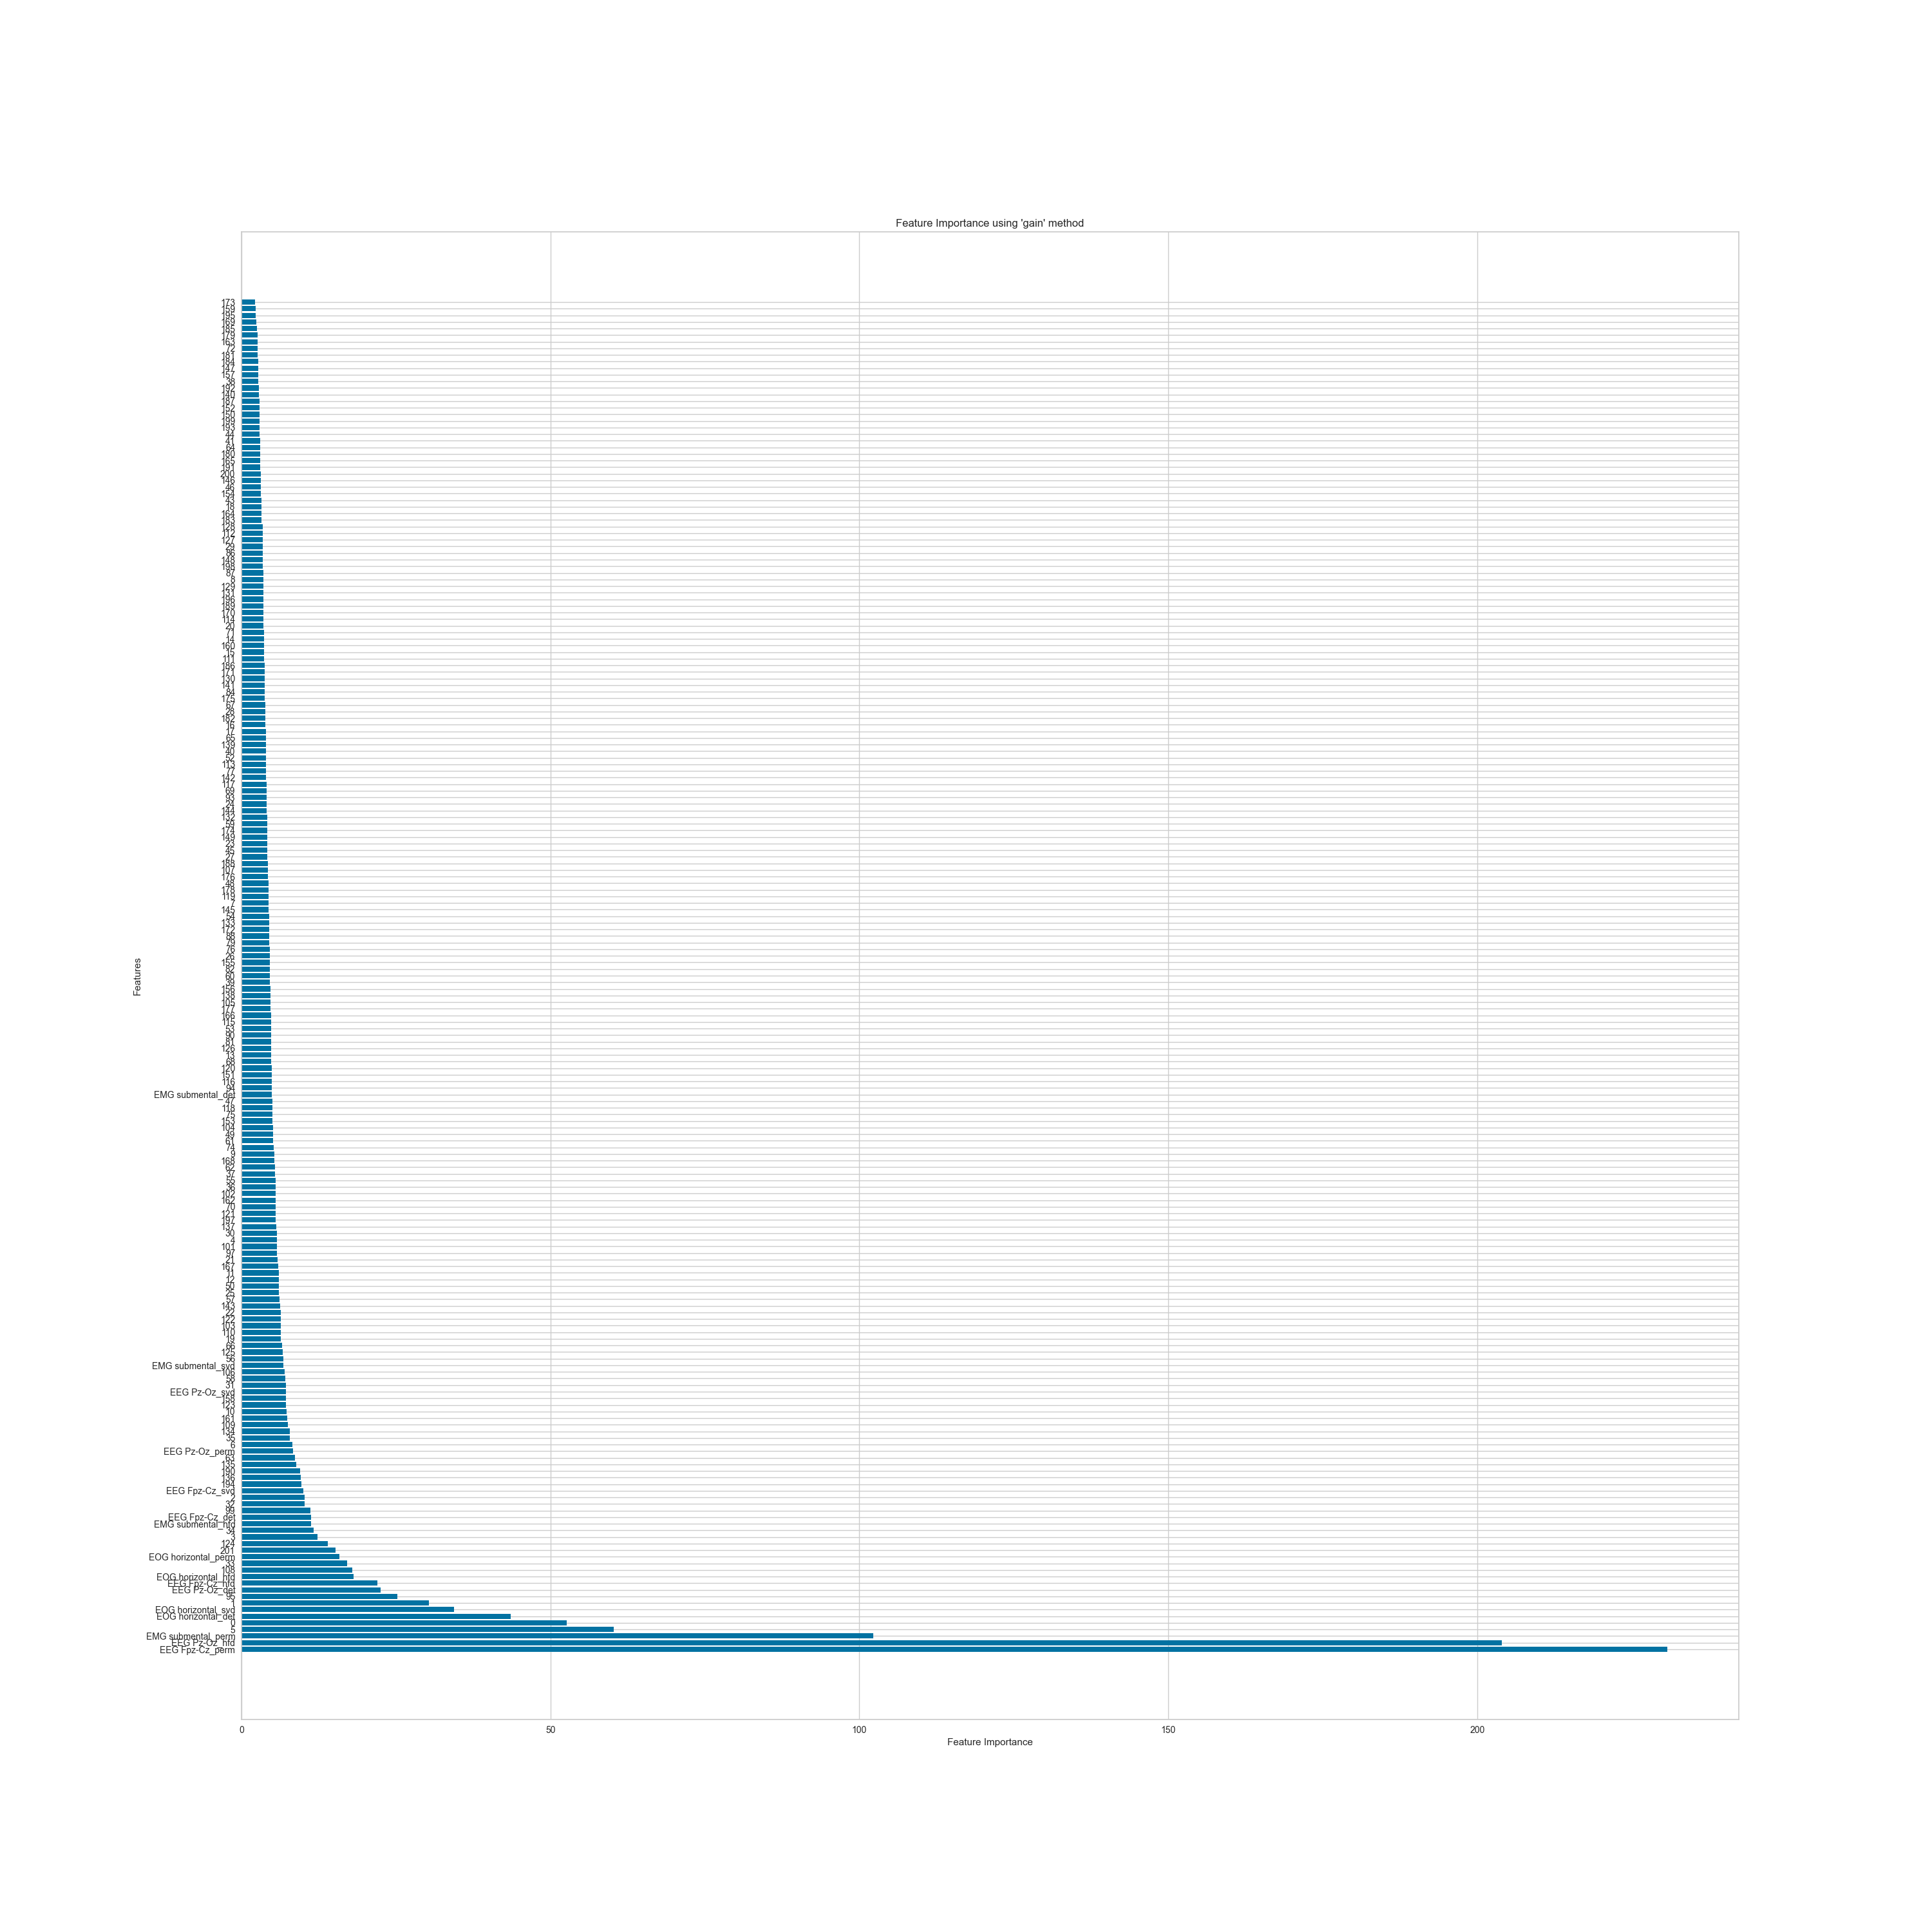

In [170]:
feeature_importance = plot_importance(xgb_psd_time)

In [185]:
# Top 100 features
feature_importances = xgb_psd_time.feature_importances_
feature_names = xgb_psd_time.feature_names_in_
# Sort the features by their importances and select the top 100
sorted_indices = np.argsort(feature_importances)[::-1]
top_100_features = sorted_indices[:100]

# Get the feature names of the top 100 most important features
top_100_feature_names = [feature_names[i] for i in top_100_features]

# Print the top 100 feature names
print("Top 100 feature names:", top_100_feature_names)


Top 100 feature names: ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_hfd', 'EMG submental_perm', '5', '0', 'EOG horizontal_det', 'EOG horizontal_svd', '1', '95', 'EEG Pz-Oz_det', 'EEG Fpz-Cz_hfd', 'EOG horizontal_hfd', '108', '33', 'EOG horizontal_perm', '201', '124', '3', '34', 'EMG submental_hfd', 'EEG Fpz-Cz_det', '99', '32', '2', 'EEG Fpz-Cz_svd', '194', '136', '190', '135', '63', 'EEG Pz-Oz_perm', '6', '35', '134', '109', '161', '10', '123', '158', 'EEG Pz-Oz_svd', '31', '58', '106', 'EMG submental_svd', '56', '125', '66', '19', '110', '103', '122', '22', '143', '57', '25', '50', '12', '11', '167', '21', '97', '101', '4', '30', '137', '197', '121', '70', '162', '102', '36', '55', '37', '62', '168', '9', '74', '61', '49', '104', '153', '75', '118', '47', 'EMG submental_det', '94', '116', '151', '120', '68', '13', '126', '81', '90', '53', '115', '166', '177', '105', '138']


In [198]:
string_list = ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_hfd', 'EMG submental_perm', '5', '0', 'EOG horizontal_det', 'EOG horizontal_svd', '1', '95']

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numerical_list = [int(x) for x in top_100_feature_names if is_number(x)]
non_numerical_list = [x for x in top_100_feature_names if not is_number(x)]

print("Numerical list:", numerical_list)
print("Non-numerical list:", non_numerical_list)


Numerical list: [5, 0, 1, 95, 108, 33, 201, 124, 3, 34, 99, 32, 2, 194, 136, 190, 135, 63, 6, 35, 134, 109, 161, 10, 123, 158, 31, 58, 106, 56, 125, 66, 19, 110, 103, 122, 22, 143, 57, 25, 50, 12, 11, 167, 21, 97, 101, 4, 30, 137, 197, 121, 70, 162, 102, 36, 55, 37, 62, 168, 9, 74, 61, 49, 104, 153, 75, 118, 47, 94, 116, 151, 120, 68, 13, 126, 81, 90, 53, 115, 166, 177, 105, 138]
Non-numerical list: ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_hfd', 'EMG submental_perm', 'EOG horizontal_det', 'EOG horizontal_svd', 'EEG Pz-Oz_det', 'EEG Fpz-Cz_hfd', 'EOG horizontal_hfd', 'EOG horizontal_perm', 'EMG submental_hfd', 'EEG Fpz-Cz_det', 'EEG Fpz-Cz_svd', 'EEG Pz-Oz_perm', 'EEG Pz-Oz_svd', 'EMG submental_svd', 'EMG submental_det']


In [201]:
X_100 = pd.concat([final_df[non_numerical_list], final_df[numerical_list], final_df['Sleep Stage']], axis=1)
X_100

EEG Fpz-Cz_perm  EEG Pz-Oz_hfd  EMG submental_perm  EOG horizontal_det  \
0             0.946917       1.892506            0.963475            1.148590   
1             0.971058       1.838841            0.999538            1.501120   
2             0.966203       1.847214            0.998407            1.395749   
3             0.978298       1.838328            0.998735            1.307505   
4             0.985030       1.809161            0.997599            1.387261   
...                ...            ...                 ...                 ...   
41485         0.968626       1.915871            0.998817            1.468160   
41486         0.975148       1.914228            0.999357            1.462729   
41487         0.956023       1.899414            0.998730            1.547991   
41488         0.978405       1.884125            0.999592            1.471581   
41489         0.942918       1.849103            0.952978            1.413490   

       EOG horizontal_svd  EEG Pz-Oz_det  EEG Fpz-Cz_hfd  EOG horizontal_hfd  \
0                0.793655       0.887048        1.729953            1.756279   
1                0.367215       1.382187        1.527066            1.621904   
2                0.439653       1.287611        1.478273            1.835012   
3                0.596802       1.441773        1.576452            1.883132   
4                0.423870       1.468738        1.520067            1.756443   
...                   ...            ...             ...                 ...   
41485            0.348455       0.926740        1.422695            1.389126   
41486            0.426211       1.077147        1.453040            1.500767   
41487            0.337180       1.014080        1.406252            1.299624   
41488            0.455389       1.212552        1.514632            1.552587   
41489            0.393394       1.155791        1.495314            1.488651   

       EOG horizontal_perm  EMG submental_hfd  ...           126  \
0                 0.953098           1.954969  ...  7.869551e-11   
1                 0.995925           2.022486  ...  2.761768e-12   
2                 0.999774           2.008475  ...  2.748428e-12   
3                 0.999406           2.011644  ...  6.117847e-12   
4                 0.999392           2.015401  ...  1.263071e-11   
...                    ...                ...  ...           ...   
41485             0.987921           1.768020  ...  6.062883e-13   
41486             0.982838           1.903348  ...  9.968959e-13   
41487             0.971756           1.946126  ...  6.387500e-13   
41488             0.994796           1.969740  ...  1.119078e-12   
41489             0.928075           1.926667  ...  1.472274e-12   

                 81            90            53           115           166  \
0      3.529095e-10  4.408566e-11  6.100985e-11  2.140516e-11  5.304065e-11   
1      5.330684e-12  3.777103e-12  2.488048e-12  3.061551e-12  1.454125e-12   
2      1.517077e-12  1.351877e-12  1.880259e-12  1.214153e-12  2.426814e-12   
3      3.477259e-12  2.355479e-12  2.972836e-12  6.565583e-12  4.655459e-12   
4      2.763122e-12  3.545309e-12  2.454674e-12  9.851232e-13  1.245465e-12   
...             ...           ...           ...           ...           ...   
41485  4.319007e-13  5.461623e-13  6.416764e-13  1.479144e-12  8.545298e-13   
41486  1.130098e-12  1.956225e-12  1.336342e-12  1.690431e-12  9.450117e-13   
41487  5.583681e-13  9.639041e-13  1.366542e-12  1.182996e-12  9.322593e-13   
41488  2.397114e-12  8.271665e-13  1.102953e-12  1.465407e-12  1.468470e-12   
41489  6.622726e-13  1.056659e-12  9.273017e-13  2.090954e-12  6.788258e-13   

                177           105           138  Sleep Stage  
0      4.233593e-11  6.205924e-11  4.283229e-11            0  
1      2.074512e-12  6.493105e-12  2.701937e-12            0  
2      2.630217e-12  2.857084e-11  3.546968e-12            0  
3      1.050636e-11  6.811364e-11  2.636284e-12        

In [203]:
clf = setup(
    data=X_100,
    target='Sleep Stage',
    session_id=123,
    fix_imbalance=True,
    normalize=True
)

In [204]:
X_100_xgb = create_model('xgboost', fold=15)

In [205]:
X_100_et = create_model('et', fold=15)

In [206]:
x_100_lgbm = create_model('lightgbm', fold=15)

## Trying all other feature extraction measures

In [238]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
   
    
    
    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    # Initialize the feature matrix
    spec_ent = np.zeros((n_epochs, n_channels))
    petrosian_fd = np.zeros((n_epochs, n_channels))
    katz_fd = np.zeros((n_epochs, n_channels))
    app_entropy = np.zeros((n_epochs, n_channels))
    sample_entropy = np.zeros((n_epochs, n_channels))
    num_zero_cross = np.zeros((n_epochs, n_channels))



    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            
            spec_ent[i, j] = ant.spectral_entropy(channel_data, sf=100, method='welch', normalize=True)
            print("spec")
            petrosian_fd[i, j] = ant.petrosian_fd(channel_data)
            print("petrosian")

            katz_fd[i, j] = ant.katz_fd(channel_data)
            app_entropy[i, j] = ant.app_entropy(channel_data, order=2, metric='chebyshev')
            sample_entropy[i, j] = ant.sample_entropy(channel_data)
            print("sample")

            num_zero_cross[i, j] = ant.num_zerocross(channel_data)


   
    X_samp = sample_entropy
    X_app = app_entropy
    X_katz = katz_fd
    X_petrosian = petrosian_fd
    X_spec = spec_ent
    X_zero = num_zero_cross

    Y = epochs_train.events[:, -1]

    return X_spec, X_petrosian, X_katz, X_app, X_samp, X_zero, Y

In [239]:
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

X_all_spec_ent, X_all_petrosian_fd, X_all_katz_fd, X_all_app_entropy, X_all_sample_entropy, X_all_num_zero_cross, Y_all = [], [], [], [], [], [], []
for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X_spec_ent, X_petrosian_fd, X_katz_fd, X_app_entropy, X_sample_entropy, X_num_zero_cross, Y = process_edf(subject)
    X_all_spec_ent.append(X_spec_ent)
    X_all_petrosian_fd.append(X_petrosian_fd)
    X_all_katz_fd.append(X_katz_fd)
    X_all_app_entropy.append(X_app_entropy)
    X_all_sample_entropy.append(X_sample_entropy)
    X_all_num_zero_cross.append(X_num_zero_cross)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

specect101
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec
petrosian
sample
spec

KeyboardInterrupt: 

In [ ]:
X_all_svd = np.vstack(X_all_svd)
X_all_hfd = np.vstack(X_all_hfd)
X_all_perm = np.vstack(X_all_perm)
X_all_det_fluc = np.vstack(X_all_det_fluc)

Y_all = np.concatenate(Y_all)

In [ ]:
df_svd = pd.DataFrame(X_all_svd)
df_hfd = pd.DataFrame(X_all_hfd)
df_perm = pd.DataFrame(X_all_perm)
df_det = pd.DataFrame(X_all_det_fluc)

df_Y = pd.DataFrame(Y_all)

In [ ]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

In [ ]:
df_svd.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_hfd.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_perm.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
df_det.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

df_svd_X = pd.concat([df_svd, df_Y], axis=1)
df_hfd_X = pd.concat([df_hfd, df_Y], axis=1)
df_perm_X = pd.concat([df_perm, df_Y], axis=1)
df_det_X = pd.concat([df_det, df_Y], axis=1)




In [ ]:
df_svd_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_hfd_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_perm_X.rename(columns={0: "Sleep Stage"}, inplace=True)
df_det_X.rename(columns={0: "Sleep Stage"}, inplace=True)

In [ ]:
X_together = pd.concat([df_svd, df_hfd, df_perm, df_det, df_Y], axis=1)
X_together.rename(columns={0: "Sleep Stage"}, inplace=True)
X_together.columns = ['EEG Fpz-Cz_svd', 'EEG Pz-Oz_svd', 'EOG horizontal_svd', 'EMG submental_svd', 'EEG Fpz-Cz_hfd', 'EEG Pz-Oz_hfd', 'EOG horizontal_hfd', 'EMG submental_hfd', 'EEG Fpz-Cz_perm', 'EEG Pz-Oz_perm', 'EOG horizontal_perm', 'EMG submental_perm', 'EEG Fpz-Cz_det', 'EEG Pz-Oz_det', 'EOG horizontal_det', 'EMG submental_det', 'Sleep Stage']
X_together

EEG Fpz-Cz_svd  EEG Pz-Oz_svd  EOG horizontal_svd  EMG submental_svd  \
0            0.987039       0.981167            0.793655           0.999226   
1            0.525045       0.530804            0.367215           0.998277   
2            0.575597       0.671199            0.439653           0.987337   
3            0.526120       0.614145            0.596802           0.999513   
4            0.376618       0.498464            0.423870           0.908455   
...               ...            ...                 ...                ...   
41485        0.460974       0.942977            0.348455           0.388256   
41486        0.513377       0.888967            0.426211           0.522939   
41487        0.517469       0.919033            0.337180           0.633221   
41488        0.529215       0.796246            0.455389           0.897802   
41489        0.520768       0.760402            0.393394           0.526894   

       EEG Fpz-Cz_hfd  EEG Pz-Oz_hfd  EOG horizontal_hfd  EMG submental_hfd  \
0            1.729953       1.892506            1.756279           1.954969   
1            1.527066       1.838841            1.621904           2.022486   
2            1.478273       1.847214            1.835012           2.008475   
3            1.576452       1.838328            1.883132           2.011644   
4            1.520067       1.809161            1.756443           2.015401   
...               ...            ...                 ...                ...   
41485        1.422695       1.915871            1.389126           1.768020   
41486        1.453040       1.914228            1.500767           1.903348   
41487        1.406252       1.899414            1.299624           1.946126   
41488        1.514632       1.884125            1.552587           1.969740   
41489        1.495314       1.849103            1.488651           1.926667   

       EEG Fpz-Cz_perm  EEG Pz-Oz_perm  EOG horizontal_perm  \
0             0.946917        0.955711             0.953098   
1             0.971058        0.983652             0.995925   
2             0.966203        0.989973             0.999774   
3             0.978298        0.987571             0.999406   
4             0.985030        0.960600             0.999392   
...                ...             ...                  ...   
41485         0.968626        0.993327             0.987921   
41486         0.975148        0.993540             0.982838   
41487         0.956023        0.993835             0.971756   
41488         0.978405        0.995693             0.994796   
41489         0.942918        0.960669             0.928075   

       EMG submental_perm  EEG Fpz-Cz_det  EEG Pz-Oz_det  EOG horizontal_det  \
0                0.963475        0.624881       0.887048            1.148590   
1                0.999538        1.345350       1.382187            1.501120   
2                0.998407        1.206655       1.287611            1.395749   
3                0.998735        1.402531       1.441773            1.307505   
4                0.997599        1.593217       1.468738            1.387261   
...                   ...             ...            ...                 ...   
41485            0.998817        1.307973       0.926740            1.468160   
41486            0.999357        1.284875       1.077147            1.462729   
41487            0.998730        1.254892       1.014080            1.547991   
41488            0.999592        1.319479       1.212552            1.471581   
41489            0.952978        1.286073       1.155791            1.413490   

       EMG submental_det  Sleep Stage  
0               0.444626            0  
1               0.681195            0  
2               0.794200            0  
3               0.678181            0  
4               0.777732            0  
...                  ...          ...  
41485           1.555474            0  
41486           1.388786            0  
41487           1.175895       

## Common Spatial Pattern

In [209]:
import os
import numpy as np
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [212]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
   
    
    
    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    # Calculate covariance matrices
    cov_matrices = Covariances().fit_transform(epochs_train.get_data())

    # Apply CSP
    csp = CSP(nfilter=4)
    csp_features = csp.fit_transform(cov_matrices, epochs_train.events[:, 2])

    return csp_features, epochs_train.events[:, 2]

In [213]:
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

X_all_csp, Y_all_csp = [], []

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X_csp, Y_csp = process_edf(subject)
    X_all_csp.append(X_csp)
    Y_all_csp.append(Y_csp)

  0%|          | 0/43 [00:00<?, ?it/s]

In [214]:
X_all_ml = np.concatenate(X_all_csp)
Y_all_ml = np.concatenate(Y_all_csp)

In [216]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

In [217]:
df_input = pd.concat([pd.DataFrame(X_all_ml), pd.DataFrame(Y_all_ml)], axis=1)
df_input.columns = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Sleep Stage']
df_input

EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  EMG submental  Sleep Stage
0        5.351436   1.682082        2.924477       2.996722            0
1        1.659854   1.603881        2.126997       1.380996            0
2        2.037858   1.438639        1.323878       0.726841            0
3        1.648611   1.196315        2.434343       2.115446            0
4        0.997372   1.002462        2.795713       1.658168            0
...           ...        ...             ...            ...          ...
41485    1.226575  -0.417921        1.120611       2.229145            0
41486    1.788571  -0.207418        1.490672       2.136617            0
41487    2.233313  -0.488999        1.322107       1.417371            0
41488    1.522550   0.275363        1.418493       1.448323            0
41489    1.934331  -0.223923        1.093407       1.833019            0

[41490 rows x 5 columns]

In [219]:
clf = setup(
    data=df_input,
    target='Sleep Stage',
    session_id=123,
    fix_imbalance=True,
    normalize=True
)

In [220]:
compare_models(fold=15)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [47]:
subject= "subject11"
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry"

In [58]:
raw = mne.io.read_raw_edf(f"{EEG_path}/{subject}/ST7011J0-PSG.edf", stim_channel='Marker', preload=True)
raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
annot_train = mne.read_annotations(f"{EEG_path}/{subject}/ST7011JP-Hypnogram.edf")
raw.set_annotations(annot_train, emit_warning=False)
raw.filter(0.3, 40)  # Filter the data with a 0.3-40 Hz bandpass

raw

<RawEDF | ST7011J0-PSG.edf, 5 x 3590000 (35900.0 s), ~137.0 MB, data loaded>

In [59]:
raw.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

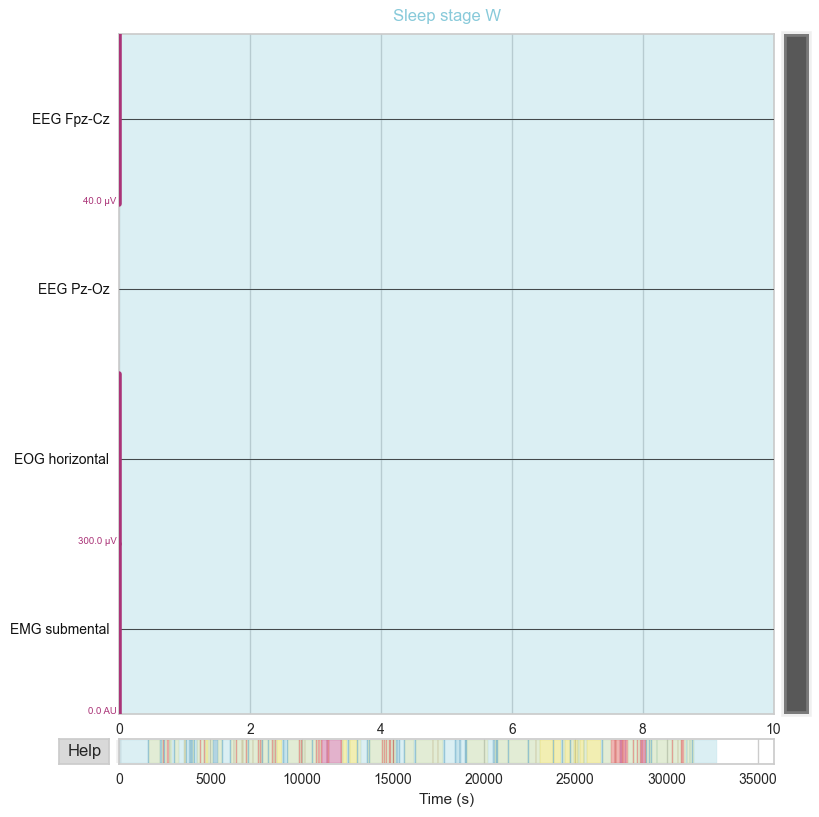

In [60]:
%matplotlib widget
raw.drop_channels(['Marker'])
raw.plot()

In [109]:
annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
}


# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)

<Annotations | 231 segments: Sleep stage 1 (52), Sleep stage 2 (82), Sleep ...>

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


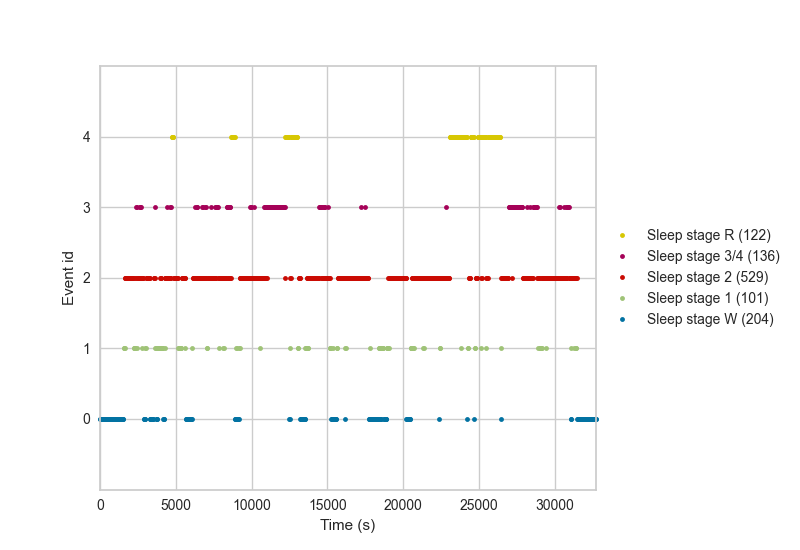

In [110]:
raw_train = raw.copy()
raw_train.set_annotations(annot_train, emit_warning=False)
events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 0,
            'Sleep stage 1': 1,
            'Sleep stage 2': 2,
            'Sleep stage 3/4': 3,
            'Sleep stage R': 4}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [113]:
# Create epochs from the event data with 30sec time window
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
1092 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1092 events (good & bad), 0 - 29.99 sec, baseline off, ~10 kB, data not loaded,
 'Sleep stage W': 204
 'Sleep stage 1': 101
 'Sleep stage 2': 529
 'Sleep stage 3/4': 136
 'Sleep stage R': 122>


Using data from preloaded Raw for 1092 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 833 events and 3000 original time points ...
Opening epochs-browser...
Using data from preloaded Raw for 10 events and 3000 original time points ...


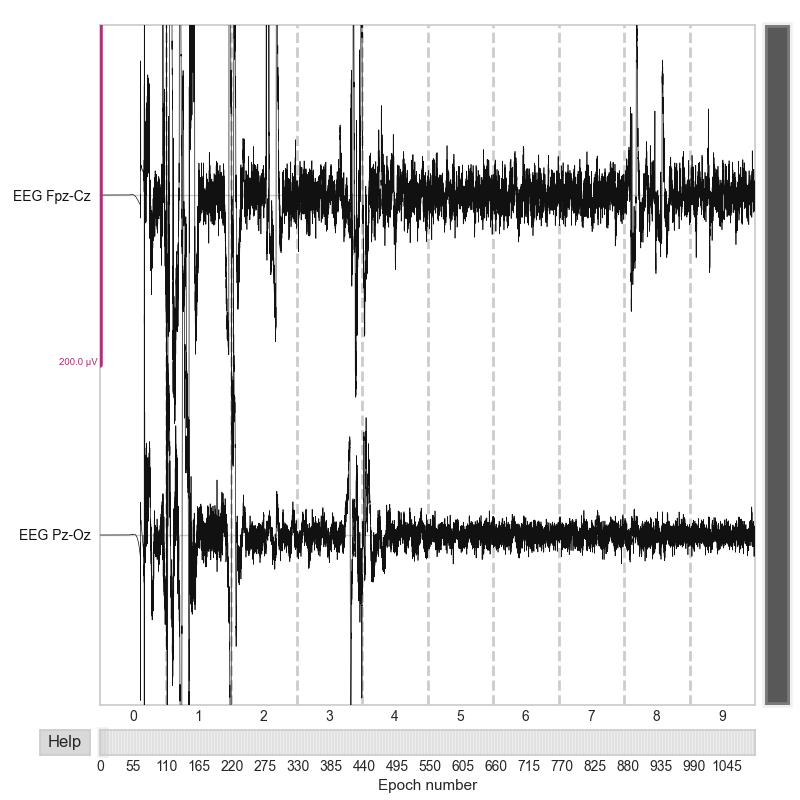

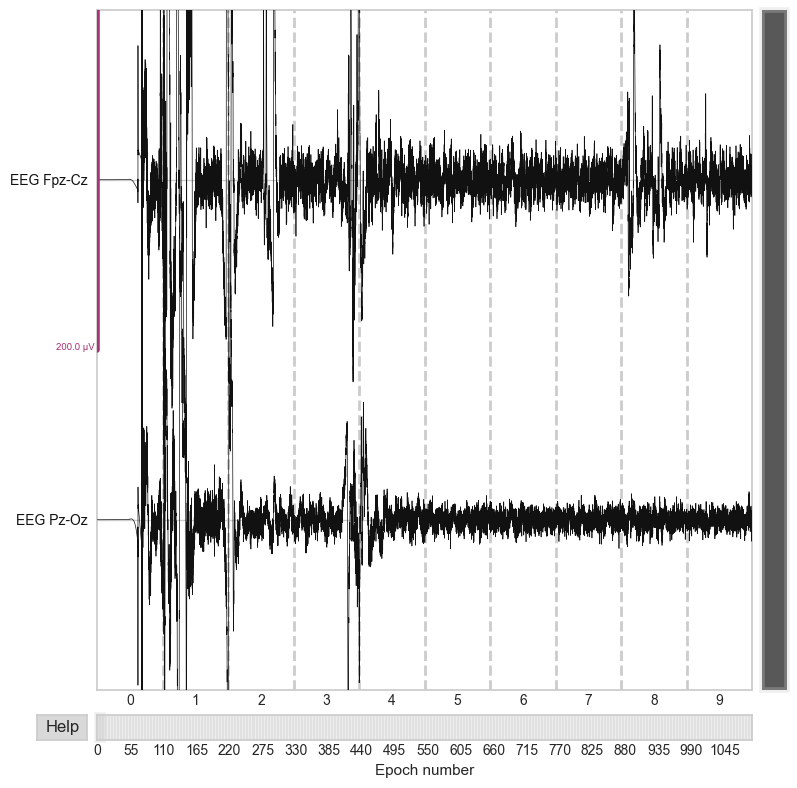

In [114]:
epochs_train.plot(n_epochs=10, scalings=dict(eeg=1e-4, eog=1e-4))

In [115]:
epochs_train.ch_names

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

In [116]:
# ant.svd_entropy(row[i-500:i], normalize=True
n_epochs = len(epochs_train)
n_channels = len(epochs_train.ch_names)
epoch_length = tmax

svd_entropies = np.zeros((n_epochs, n_channels))
for i, epoch in enumerate(epochs_train.get_data()):
    for j, channel_data in enumerate(epoch):
        svd_entropies[i, j] = ant.svd_entropy(channel_data)

Using data from preloaded Raw for 1092 events and 3000 original time points ...


# PyCaret

In [117]:
X = svd_entropies
Y = epochs_train.events[:, -1]

In [118]:
df_X = pd.DataFrame(X)
df_X

0         1         2         3             4
0     1.522835  1.542042  1.493258  1.456832  1.671704e-01
1     0.595168  0.587296  0.666664  0.876497  5.486582e-01
2     0.614239  0.518331  0.584655  0.288038  2.659164e-13
3     0.766890  0.813239  0.441630  0.393287  2.659164e-13
4     0.983507  0.894284  0.820729  0.315678  2.659164e-13
...        ...       ...       ...       ...           ...
1087  0.759019  1.002160  0.879981  1.336844  2.659164e-13
1088  0.520588  0.899578  0.436411  1.080546  2.659164e-13
1089  0.487298  1.299801  0.839142  1.383960  2.659164e-13
1090  0.882192  0.998225  0.635451  1.521023  2.659164e-13
1091  0.413102  0.351329  0.537663  1.481232  9.545330e-01

[1092 rows x 5 columns]

In [119]:
df_Y = pd.DataFrame(Y)
df_Y.value_counts()

2    529
0    204
3    136
4    122
1    101
dtype: int64

In [120]:
df_input = pd.concat([df_X, df_Y], axis=1)
df_input.columns = epochs_train.ch_names+['Sleep stage']
df_input

EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  EMG submental        Marker  \
0       1.522835   1.542042        1.493258       1.456832  1.671704e-01   
1       0.595168   0.587296        0.666664       0.876497  5.486582e-01   
2       0.614239   0.518331        0.584655       0.288038  2.659164e-13   
3       0.766890   0.813239        0.441630       0.393287  2.659164e-13   
4       0.983507   0.894284        0.820729       0.315678  2.659164e-13   
...          ...        ...             ...            ...           ...   
1087    0.759019   1.002160        0.879981       1.336844  2.659164e-13   
1088    0.520588   0.899578        0.436411       1.080546  2.659164e-13   
1089    0.487298   1.299801        0.839142       1.383960  2.659164e-13   
1090    0.882192   0.998225        0.635451       1.521023  2.659164e-13   
1091    0.413102   0.351329        0.537663       1.481232  9.545330e-01   

      Sleep stage  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
1087            0  
1088            0  
1089            0  
1090            0  
1091            0  

[1092 rows x 6 columns]

In [121]:
clf = setup(
    data=df_input, 
    target='Sleep stage', 
    session_id=123, 
    fix_imbalance=True,
    normalize=True
    )

In [122]:
compare_models()

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
clf = SVC(kernel='linear', class_weight='balanced', C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11  8  3 11  3]
 [ 3 13  4  1  0]
 [10  9 72  8  8]
 [ 1  0  9 27  0]
 [ 0  2  2  0 14]]
              precision    recall  f1-score   support

           0       0.44      0.31      0.36        36
           1       0.41      0.62      0.49        21
           2       0.80      0.67      0.73       107
           3       0.57      0.73      0.64        37
           4       0.56      0.78      0.65        18

    accuracy                           0.63       219
   macro avg       0.56      0.62      0.58       219
weighted avg       0.65      0.63      0.63       219



In [ ]:
clf = setup(data=hfd_ml[hfd_ml['Y']!=1.0], target='Y', 
            session_id=123, 
            # feature_selection=True, feature_selection_threshold=0.9, feature_selection_method='boruta', 
            fix_imbalance=True
            )